In [60]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, DataCollatorForTokenClassification
from sklearn.metrics import confusion_matrix
from seqeval.metrics import classification_report, f1_score

from CoNLL2003_desc import desc

device = "cuda" if torch.cuda.is_available() else "cpu"

In [26]:
dataset = "lhoestq/conll2003"

train_ds = load_dataset(dataset, split="train")
val_ds = load_dataset(dataset, split="validation")
test_ds = load_dataset(dataset, split="test")

train_ds, val_ds, test_ds

(Dataset({
     features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
     num_rows: 14041
 }),
 Dataset({
     features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
     num_rows: 3250
 }),
 Dataset({
     features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
     num_rows: 3453
 }))

In [27]:
features = desc["lhoestq--conll2003"]["features"]

features["ner_tags"]

{'feature': {'num_classes': 9,
  'names': ['O',
   'B-PER',
   'I-PER',
   'B-ORG',
   'I-ORG',
   'B-LOC',
   'I-LOC',
   'B-MISC',
   'I-MISC'],
  'names_file': None,
  'id': None,
  '_type': 'ClassLabel'},
 'length': -1,
 'id': None,
 '_type': 'Sequence'}

In [28]:
labels = features["ner_tags"]["feature"]["names"]

labels, len(labels)

(['O',
  'B-PER',
  'I-PER',
  'B-ORG',
  'I-ORG',
  'B-LOC',
  'I-LOC',
  'B-MISC',
  'I-MISC'],
 9)

In [29]:
train_ds[1]

{'id': '1',
 'tokens': ['Peter', 'Blackburn'],
 'pos_tags': [22, 22],
 'chunk_tags': [11, 12],
 'ner_tags': [1, 2]}

In [30]:
model_name = "distilbert-base-cased" # cased for token classification

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForTokenClassification.from_pretrained(
    model_name,
    num_labels=len(labels),
)

model.to(device)

Loading weights: 100%|██████████| 100/100 [00:00<00:00, 1310.76it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]   
DistilBertForTokenClassification LOAD REPORT from: distilbert-base-cased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_layer_norm.weight | UNEXPECTED | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSelfAttention(
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
   

In [31]:
def tokenize_and_align_ner(batch):
    tokenized = tokenizer(
        batch["tokens"],
        truncation=True,
        is_split_into_words=True # mark that each word is already seperated
    )

    all_labels = []

    for i in range(len(batch["tokens"])):
        word_ids = tokenized.word_ids(batch_index=i)
        example_labels = []
        previous = None

        for idx in word_ids:
            if idx is None:
                example_labels.append(-100)
            else:
                if idx != previous:
                    example_labels.append(batch["ner_tags"][i][idx])
                else:
                    example_labels.append(-100)
                previous = idx

        all_labels.append(example_labels)

    tokenized["labels"] = all_labels
    return tokenized


tokenized_train = train_ds.map(tokenize_and_align_ner, batched=True, batch_size=1024)
tokenized_val = val_ds.map(tokenize_and_align_ner, batched=True, batch_size=1024)
tokenized_test = test_ds.map(tokenize_and_align_ner, batched=True, batch_size=1024)

Map: 100%|██████████| 3250/3250 [00:00<00:00, 11075.12 examples/s]


In [32]:
tokenized_train

Dataset({
    features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
    num_rows: 14041
})

In [33]:
tokenized_train[0]

{'id': '0',
 'tokens': ['EU',
  'rejects',
  'German',
  'call',
  'to',
  'boycott',
  'British',
  'lamb',
  '.'],
 'pos_tags': [22, 42, 16, 21, 35, 37, 16, 21, 7],
 'chunk_tags': [11, 21, 11, 12, 21, 22, 11, 12, 0],
 'ner_tags': [3, 0, 7, 0, 0, 0, 7, 0, 0],
 'input_ids': [101,
  7270,
  22961,
  1528,
  1840,
  1106,
  21423,
  1418,
  2495,
  12913,
  119,
  102],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
 'labels': [-100, 3, 0, 7, 0, 0, 0, 7, 0, -100, 0, -100]}

In [34]:
label_list = desc["lhoestq--conll2003"]["features"]["ner_tags"]["feature"]["names"]

def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)  # logits → class indices

    # Remove ignored index (-100)
    true_labels = []
    true_predictions = []

    for pred_seq, label_seq in zip(predictions, labels):
        temp_pred = []
        temp_label = []
        for p_idx, l_idx in zip(pred_seq, label_seq):
            if l_idx != -100:  # ignore special tokens & subwords
                temp_pred.append(label_list[p_idx])
                temp_label.append(label_list[l_idx])
        true_predictions.append(temp_pred)
        true_labels.append(temp_label)

    # Compute F1 score
    return {
        "f1": f1_score(true_labels, true_predictions),
        "report": classification_report(true_labels, true_predictions)
    }

In [35]:
LR = 2e-5
BATCH_SIZE = 16
NUM_EPOCH = 3
output_path = "./results/conll2003"

training_args = TrainingArguments(
    output_dir=output_path,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LR,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCH,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
    fp16=True
)

In [36]:
data_collator = DataCollatorForTokenClassification(tokenizer)

In [37]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1,Report
1,0.073400,0.054137,0.912486,precision recall f1-score support LOC 0.94 0.94 0.94 1837 MISC 0.82 0.81 0.81 922 ORG 0.84 0.92 0.88 1341 PER 0.97 0.94 0.96 1842 micro avg 0.91 0.92 0.91 5942 macro avg 0.89 0.90 0.90 5942 weighted avg 0.91 0.92 0.91 5942
2,0.029505,0.050058,0.927169,precision recall f1-score support LOC 0.95 0.95 0.95 1837 MISC 0.83 0.87 0.85 922 ORG 0.92 0.89 0.90 1341 PER 0.96 0.97 0.96 1842 micro avg 0.92 0.93 0.93 5942 macro avg 0.91 0.92 0.92 5942 weighted avg 0.93 0.93 0.93 5942
3,0.016361,0.046151,0.932908,precision recall f1-score support LOC 0.96 0.95 0.96 1837 MISC 0.85 0.88 0.86 922 ORG 0.90 0.91 0.91 1341 PER 0.96 0.96 0.96 1842 micro avg 0.93 0.94 0.93 5942 macro avg 0.92 0.93 0.92 5942 weighted avg 0.93 0.94 0.93 5942


Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  7.51it/s]
There were missing keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.weight', 'distilbert.embeddings.LayerNorm.bias'].
There were unexpected keys in the checkpoint model loaded: ['distilbert.embeddings.LayerNorm.beta', 'distilbert.embeddings.LayerNorm.gamma'].


TrainOutput(global_step=2634, training_loss=0.03703902106259751, metrics={'train_runtime': 62.1441, 'train_samples_per_second': 677.827, 'train_steps_per_second': 42.385, 'total_flos': 573977608222536.0, 'train_loss': 0.03703902106259751, 'epoch': 3.0})

In [40]:
trainer.save_model(output_path)
tokenizer.save_pretrained(output_path)

Writing model shards: 100%|██████████| 1/1 [00:00<00:00,  5.32it/s]


('./results/conll2003\\tokenizer_config.json',
 './results/conll2003\\tokenizer.json')

In [41]:
output_path = "./results/conll2003"

tokenizer = AutoTokenizer.from_pretrained(output_path)
model = AutoModelForTokenClassification.from_pretrained(output_path)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

Loading weights: 100%|██████████| 102/102 [00:00<00:00, 1265.80it/s, Materializing param=distilbert.transformer.layer.5.sa_layer_norm.weight]    


In [42]:
eval_results = trainer.evaluate(eval_dataset=tokenized_val)
eval_results

{'eval_loss': 0.04615107551217079,
 'eval_model_preparation_time': 0.0022,
 'eval_f1': 0.9329084199932908,
 'eval_report': '              precision    recall  f1-score   support\n\n         LOC       0.96      0.95      0.96      1837\n        MISC       0.85      0.88      0.86       922\n         ORG       0.90      0.91      0.91      1341\n         PER       0.96      0.96      0.96      1842\n\n   micro avg       0.93      0.94      0.93      5942\n   macro avg       0.92      0.93      0.92      5942\nweighted avg       0.93      0.94      0.93      5942\n',
 'eval_runtime': 1.3765,
 'eval_samples_per_second': 2360.994,
 'eval_steps_per_second': 148.198}

In [47]:
print(eval_results['eval_report'])

              precision    recall  f1-score   support

         LOC       0.96      0.95      0.96      1837
        MISC       0.85      0.88      0.86       922
         ORG       0.90      0.91      0.91      1341
         PER       0.96      0.96      0.96      1842

   micro avg       0.93      0.94      0.93      5942
   macro avg       0.92      0.93      0.92      5942
weighted avg       0.93      0.94      0.93      5942



In [43]:
pred = trainer.predict(test_dataset=tokenized_test)
pred.metrics

{'test_loss': 0.12448601424694061,
 'test_model_preparation_time': 0.0022,
 'test_f1': 0.8866123807022152,
 'test_report': '              precision    recall  f1-score   support\n\n         LOC       0.92      0.91      0.91      1668\n        MISC       0.71      0.79      0.74       702\n         ORG       0.85      0.88      0.86      1661\n         PER       0.95      0.94      0.95      1617\n\n   micro avg       0.88      0.90      0.89      5648\n   macro avg       0.86      0.88      0.87      5648\nweighted avg       0.88      0.90      0.89      5648\n',
 'test_runtime': 1.6107,
 'test_samples_per_second': 2143.801,
 'test_steps_per_second': 134.104}

In [49]:
print(pred.metrics['test_report'])

              precision    recall  f1-score   support

         LOC       0.92      0.91      0.91      1668
        MISC       0.71      0.79      0.74       702
         ORG       0.85      0.88      0.86      1661
         PER       0.95      0.94      0.95      1617

   micro avg       0.88      0.90      0.89      5648
   macro avg       0.86      0.88      0.87      5648
weighted avg       0.88      0.90      0.89      5648



In [55]:
pred.predictions, pred.label_ids

(array([[[ 5.14062500e+00, -5.75683594e-01, -1.22753906e+00, ...,
          -1.12792969e+00, -7.22656250e-01, -8.26171875e-01],
         [ 8.49218750e+00, -4.49462891e-01, -2.31835938e+00, ...,
          -2.33593750e+00, -1.76855469e+00, -2.40625000e+00],
         [ 7.01171875e+00, -1.23242188e+00, -1.74707031e+00, ...,
          -2.06835938e+00, -2.12304688e+00, -7.29492188e-01],
         ...,
         [-1.00000000e+02, -1.00000000e+02, -1.00000000e+02, ...,
          -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
         [-1.00000000e+02, -1.00000000e+02, -1.00000000e+02, ...,
          -1.00000000e+02, -1.00000000e+02, -1.00000000e+02],
         [-1.00000000e+02, -1.00000000e+02, -1.00000000e+02, ...,
          -1.00000000e+02, -1.00000000e+02, -1.00000000e+02]],
 
        [[ 1.71679688e+00,  3.16894531e-01, -7.06787109e-02, ...,
          -2.81494141e-01, -3.77197266e-01, -1.89086914e-01],
         [ 1.72119141e-01,  6.39453125e+00, -8.24707031e-01, ...,
          -2.54296875

In [56]:
# predictions are 2D: [num_samples, seq_length] -> argmax on last axis
pred_labels = np.argmax(pred.predictions, axis=2)
pred_labels.shape, pred.label_ids.shape

((3453, 148), (3453, 148))

In [57]:
# Flatten predictions and labels, filtering out -100 (special tokens / subwords)
flat_preds = []
flat_labels = []

for pred_seq, label_seq in zip(pred_labels, pred.label_ids):
    for p, l in zip(pred_seq, label_seq):
        if l != -100:
            flat_preds.append(label_list[p])
            flat_labels.append(label_list[l])

y_df = pd.DataFrame({
    "predicted": flat_preds,
    "true": flat_labels,
})
y_df.head(20)

,predicted,true
0,O,O
1,O,O
2,B-PER,B-LOC
3,O,O
4,O,O
5,O,O
6,O,O
7,B-ORG,B-PER
8,O,O
9,B-MISC,O


In [58]:
# Visualize a single sentence: tokens vs predicted vs true labels
def show_sentence(idx):
    tokens = test_ds[idx]["tokens"]
    true_tags = [label_list[t] for t in test_ds[idx]["ner_tags"]]

    # Get model predictions for this sentence (aligned to words)
    word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()
    preds_for_sentence = pred_labels[idx]

    pred_tags = []
    prev = None
    pi = 0
    for wid in word_ids:
        if wid is None:
            pi += 1
            continue
        if wid != prev:
            pred_tags.append(label_list[preds_for_sentence[pi]])
            prev = wid
        pi += 1

    df = pd.DataFrame({
        "Token": tokens,
        "True": true_tags,
        "Predicted": pred_tags[:len(tokens)],
    })
    # Highlight mismatches
    def highlight(row):
        color = "background-color: #ffcccc" if row["True"] != row["Predicted"] else ""
        return [color] * len(row)

    return df.style.apply(highlight, axis=1)

show_sentence(0)

,Token,True,Predicted
0,SOCCER,O,O
1,-,O,O
2,JAPAN,B-LOC,B-PER
3,GET,O,O
4,LUCKY,O,O
5,WIN,O,O
6,",",O,O
7,CHINA,B-PER,B-ORG
8,IN,O,O
9,SURPRISE,O,B-MISC


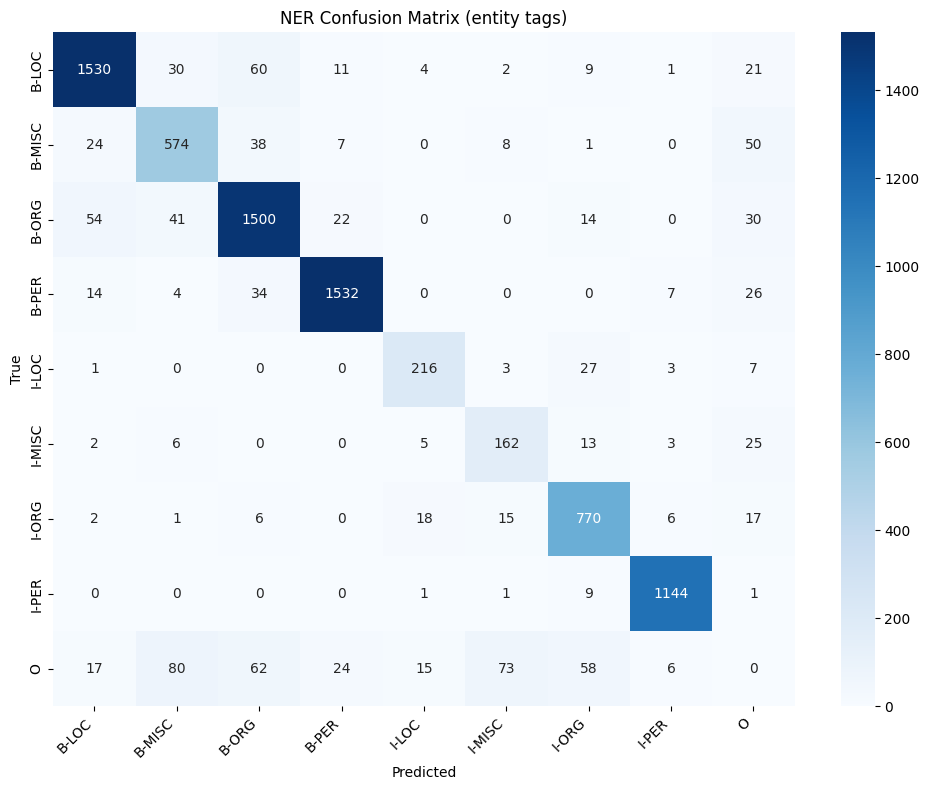

In [ ]:
entity_preds = [p for p, l in zip(flat_preds, flat_labels) if l != "O" or p != "O"]
entity_labels = [l for p, l in zip(flat_preds, flat_labels) if l != "O" or p != "O"]

unique_tags = sorted(set(entity_labels + entity_preds))

cm = confusion_matrix(entity_labels, entity_preds, labels=unique_tags)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=unique_tags, yticklabels=unique_tags)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("NER Confusion Matrix (entity tags)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## Raw Inference (Pytorch)

In [61]:
texts = [
    "Barack Obama was born in Honolulu, Hawaii.",
    "Apple Inc. is headquartered in Cupertino, California.",
    "The United Nations held a meeting in New York last Friday."
]

# Tokenize each sentence (pre-split into words)
for text in texts:
    tokens = text.split()

    inputs = tokenizer(
        tokens,
        is_split_into_words=True,
        return_tensors="pt",
        truncation=True,
    )

    # move to model device
    inputs = {k: v.to(model.device) for k, v in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        preds = torch.argmax(outputs.logits, dim=-1)[0]

    # Align predictions back to original words (skip subtokens)
    word_ids = inputs_word_ids = tokenizer(tokens, is_split_into_words=True).word_ids()
    results = []
    prev_word_id = None

    for idx, word_id in enumerate(word_ids):
        if word_id is None:
            continue
        if word_id != prev_word_id:
            results.append((tokens[word_id], label_list[preds[idx].item()]))
        prev_word_id = word_id

    # Print results, highlighting entities
    print(f"Input: {text}")
    for token, tag in results:
        if tag != "O":
            print(f"  {token:20s} → {tag}")
    print()

Input: Barack Obama was born in Honolulu, Hawaii.
  Barack               → B-PER
  Obama                → I-PER
  Honolulu,            → B-LOC
  Hawaii.              → B-LOC

Input: Apple Inc. is headquartered in Cupertino, California.
  Apple                → B-ORG
  Inc.                 → I-ORG
  Cupertino,           → B-LOC
  California.          → B-LOC

Input: The United Nations held a meeting in New York last Friday.
  United               → B-ORG
  Nations              → I-ORG
  New                  → B-LOC
  York                 → I-LOC

